In [1]:
!pip install -q --no-index --find-links=/kaggle/input/pip-install-lifelines lifelines

  Preparing metadata (setup.py) ... done


# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from scipy import stats
from warnings import filterwarnings
from xgboost import XGBRegressor, XGBClassifier
from  lightgbm import LGBMRegressor,LGBMClassifier,log_evaluation,early_stopping, callback
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter
import joblib
from colorama import Fore, Back, Style

filterwarnings('ignore')

# EDA

In [3]:
# Load data
train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')
data_dict = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv')

# Basic exploration
print("Dataset shape:", train.shape)
print("\nFirst 5 rows:")
display(train.head())

# Target variable analysis
print("\nTarget variable distribution:")
print(train['efs'].value_counts(normalize=True))


Dataset shape: (28800, 60)

First 5 rows:


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223



Target variable distribution:
efs
1.0    0.539306
0.0    0.460694
Name: proportion, dtype: float64


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

In [5]:
train.nunique()

ID                        28800
dri_score                    11
psych_disturb                 3
cyto_score                    7
diabetes                      3
hla_match_c_high              3
hla_high_res_8                7
tbi_status                    8
arrhythmia                    3
hla_low_res_6                 5
graft_type                    2
vent_hist                     2
renal_issue                   3
pulm_severe                   3
prim_disease_hct             18
hla_high_res_6                6
cmv_status                    4
hla_high_res_10               8
hla_match_dqb1_high           3
tce_imm_match                 8
hla_nmdp_6                    5
hla_match_c_low               3
rituximab                     2
hla_match_drb1_low            2
hla_match_dqb1_low            3
prod_type                     2
cyto_score_detail             5
conditioning_intensity        6
ethnicity                     3
year_hct                     13
obesity                       3
mrd_hct 

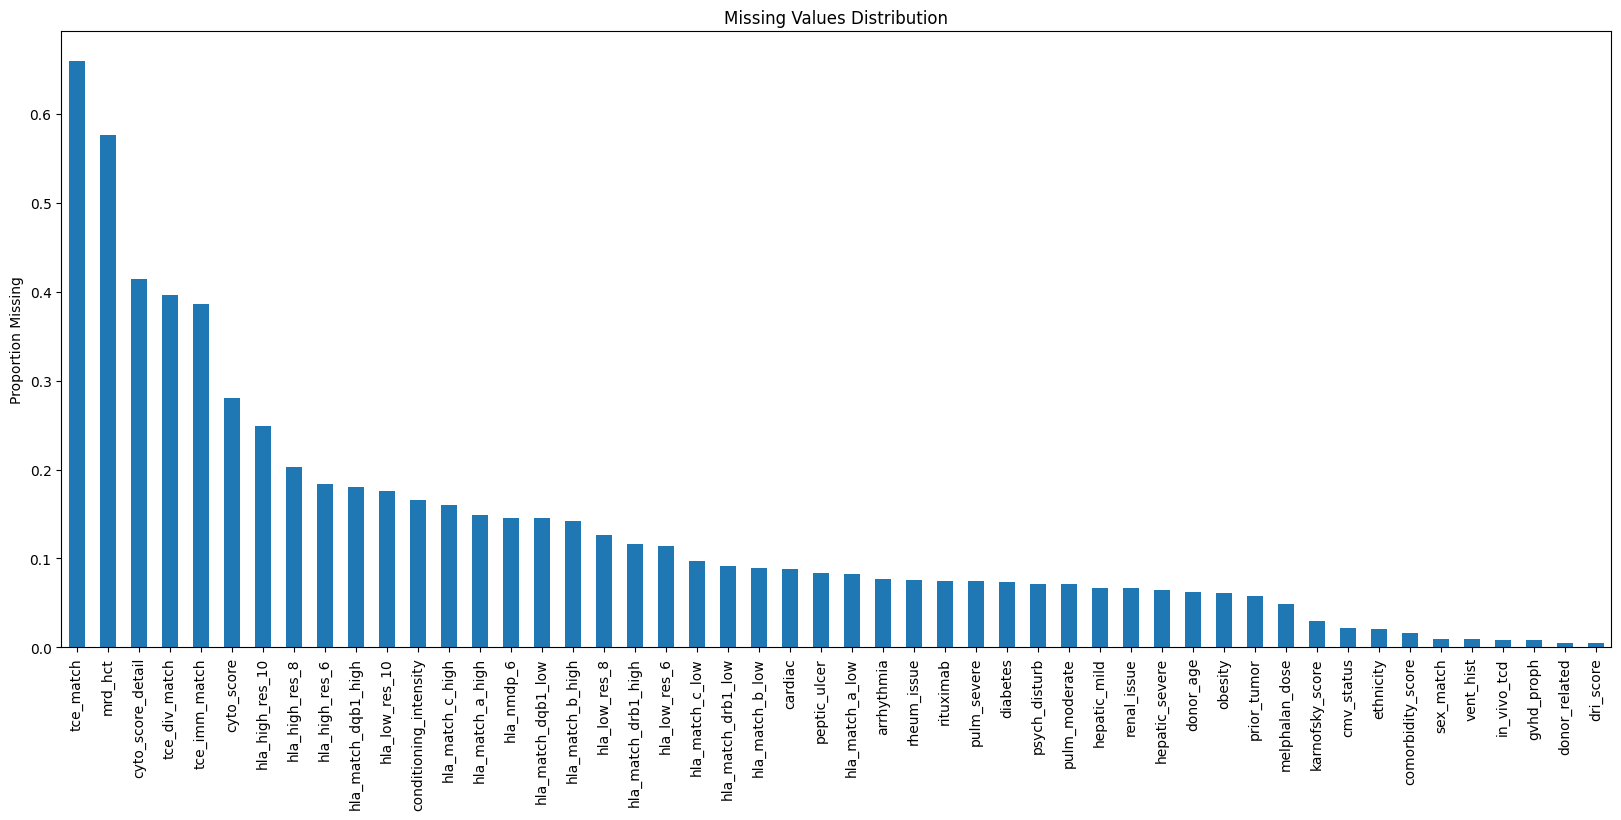

In [6]:

# Missing values analysis
plt.figure(figsize=(20, 8))
missing = train.isna().mean().sort_values(ascending=False)
missing[missing > 0].plot(kind='bar', title='Missing Values Distribution')
plt.ylabel('Proportion Missing')
plt.show()



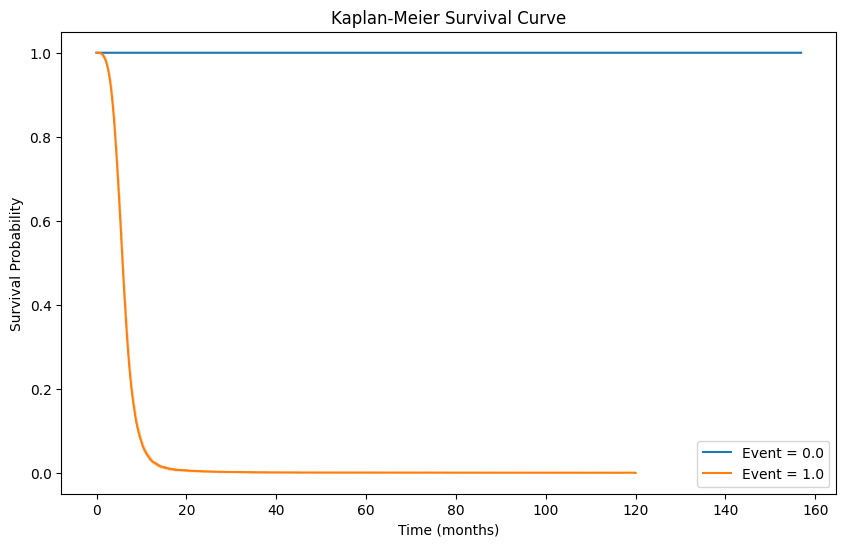

In [7]:
# Survival analysis visualization
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

for name, grouped_df in train.groupby('efs'):
    kmf.fit(grouped_df["efs_time"], 
            grouped_df["efs"], 
            label=f'Event = {name}')
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.show()



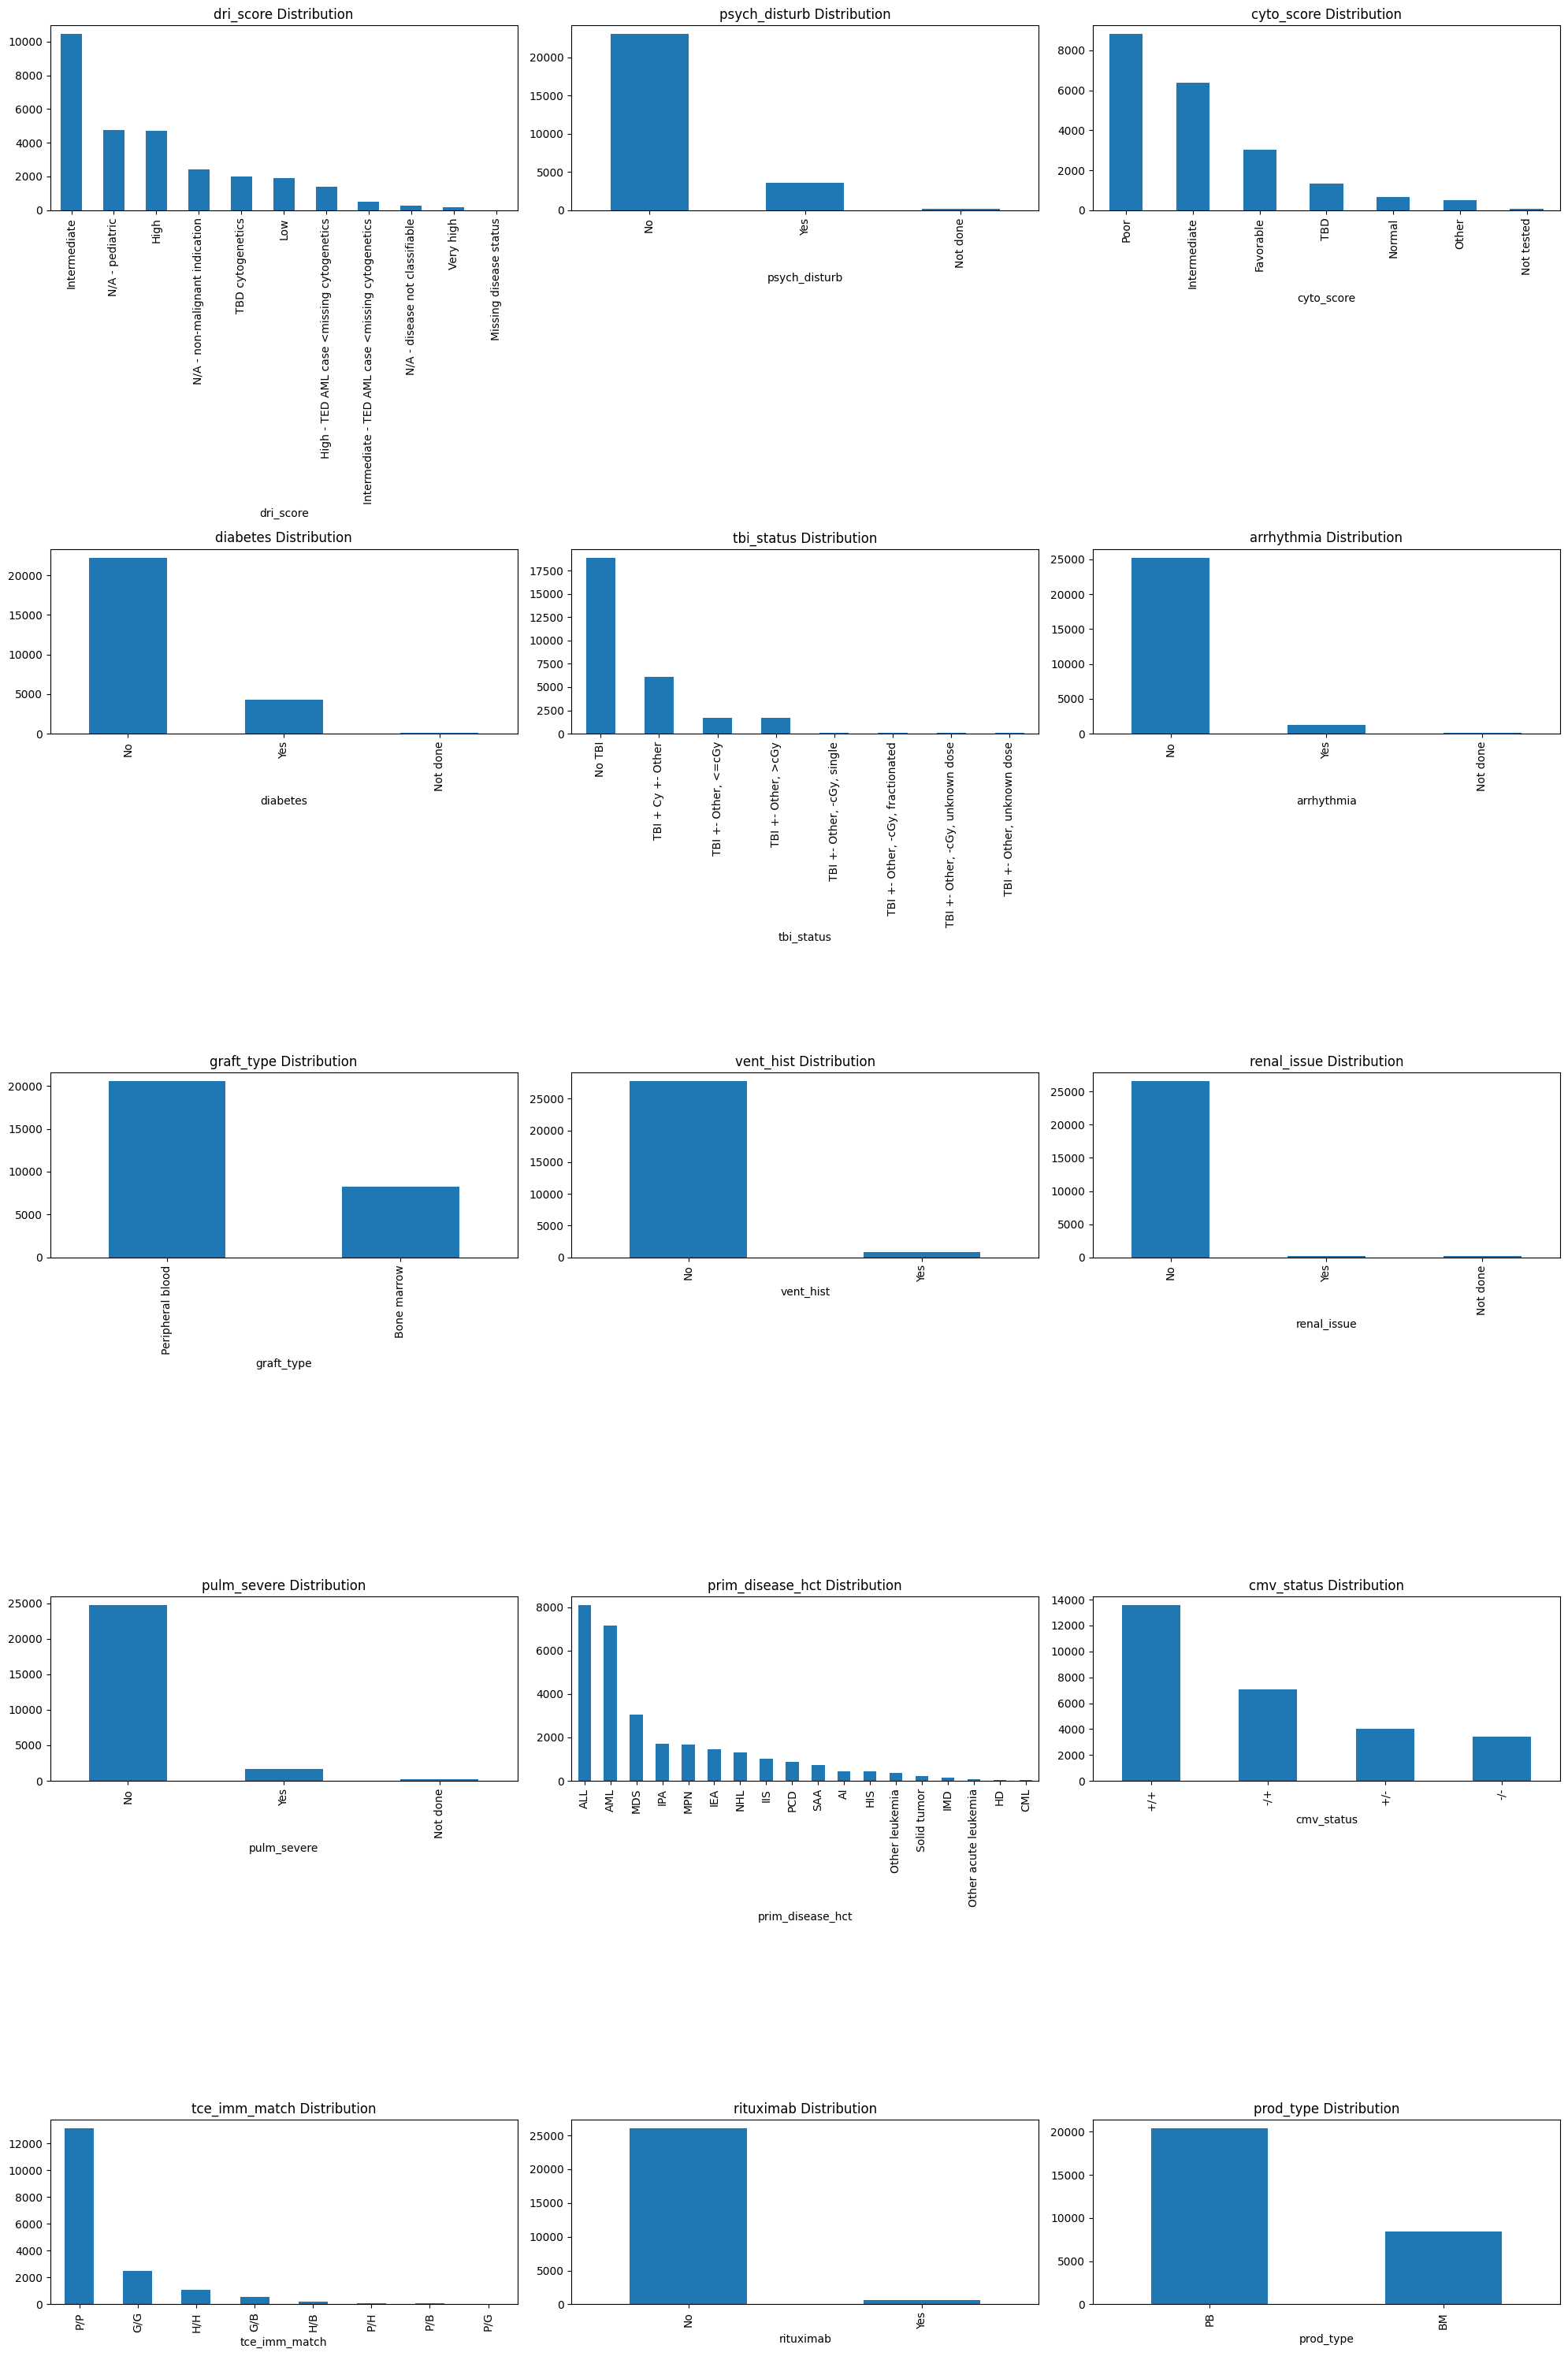

In [8]:
# Categorical variables analysis
cat_cols = data_dict[data_dict['type'] == 'Categorical']['variable'].tolist()
cat_cols = [c for c in cat_cols if c in train.columns and c not in ['efs', 'efs_time']]

plt.figure(figsize=(20, 30))
for i, col in enumerate(cat_cols[:15]):  # First 15 categorical features
    plt.subplot(5, 3, i+1)
    train[col].value_counts().plot(kind='bar')
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()


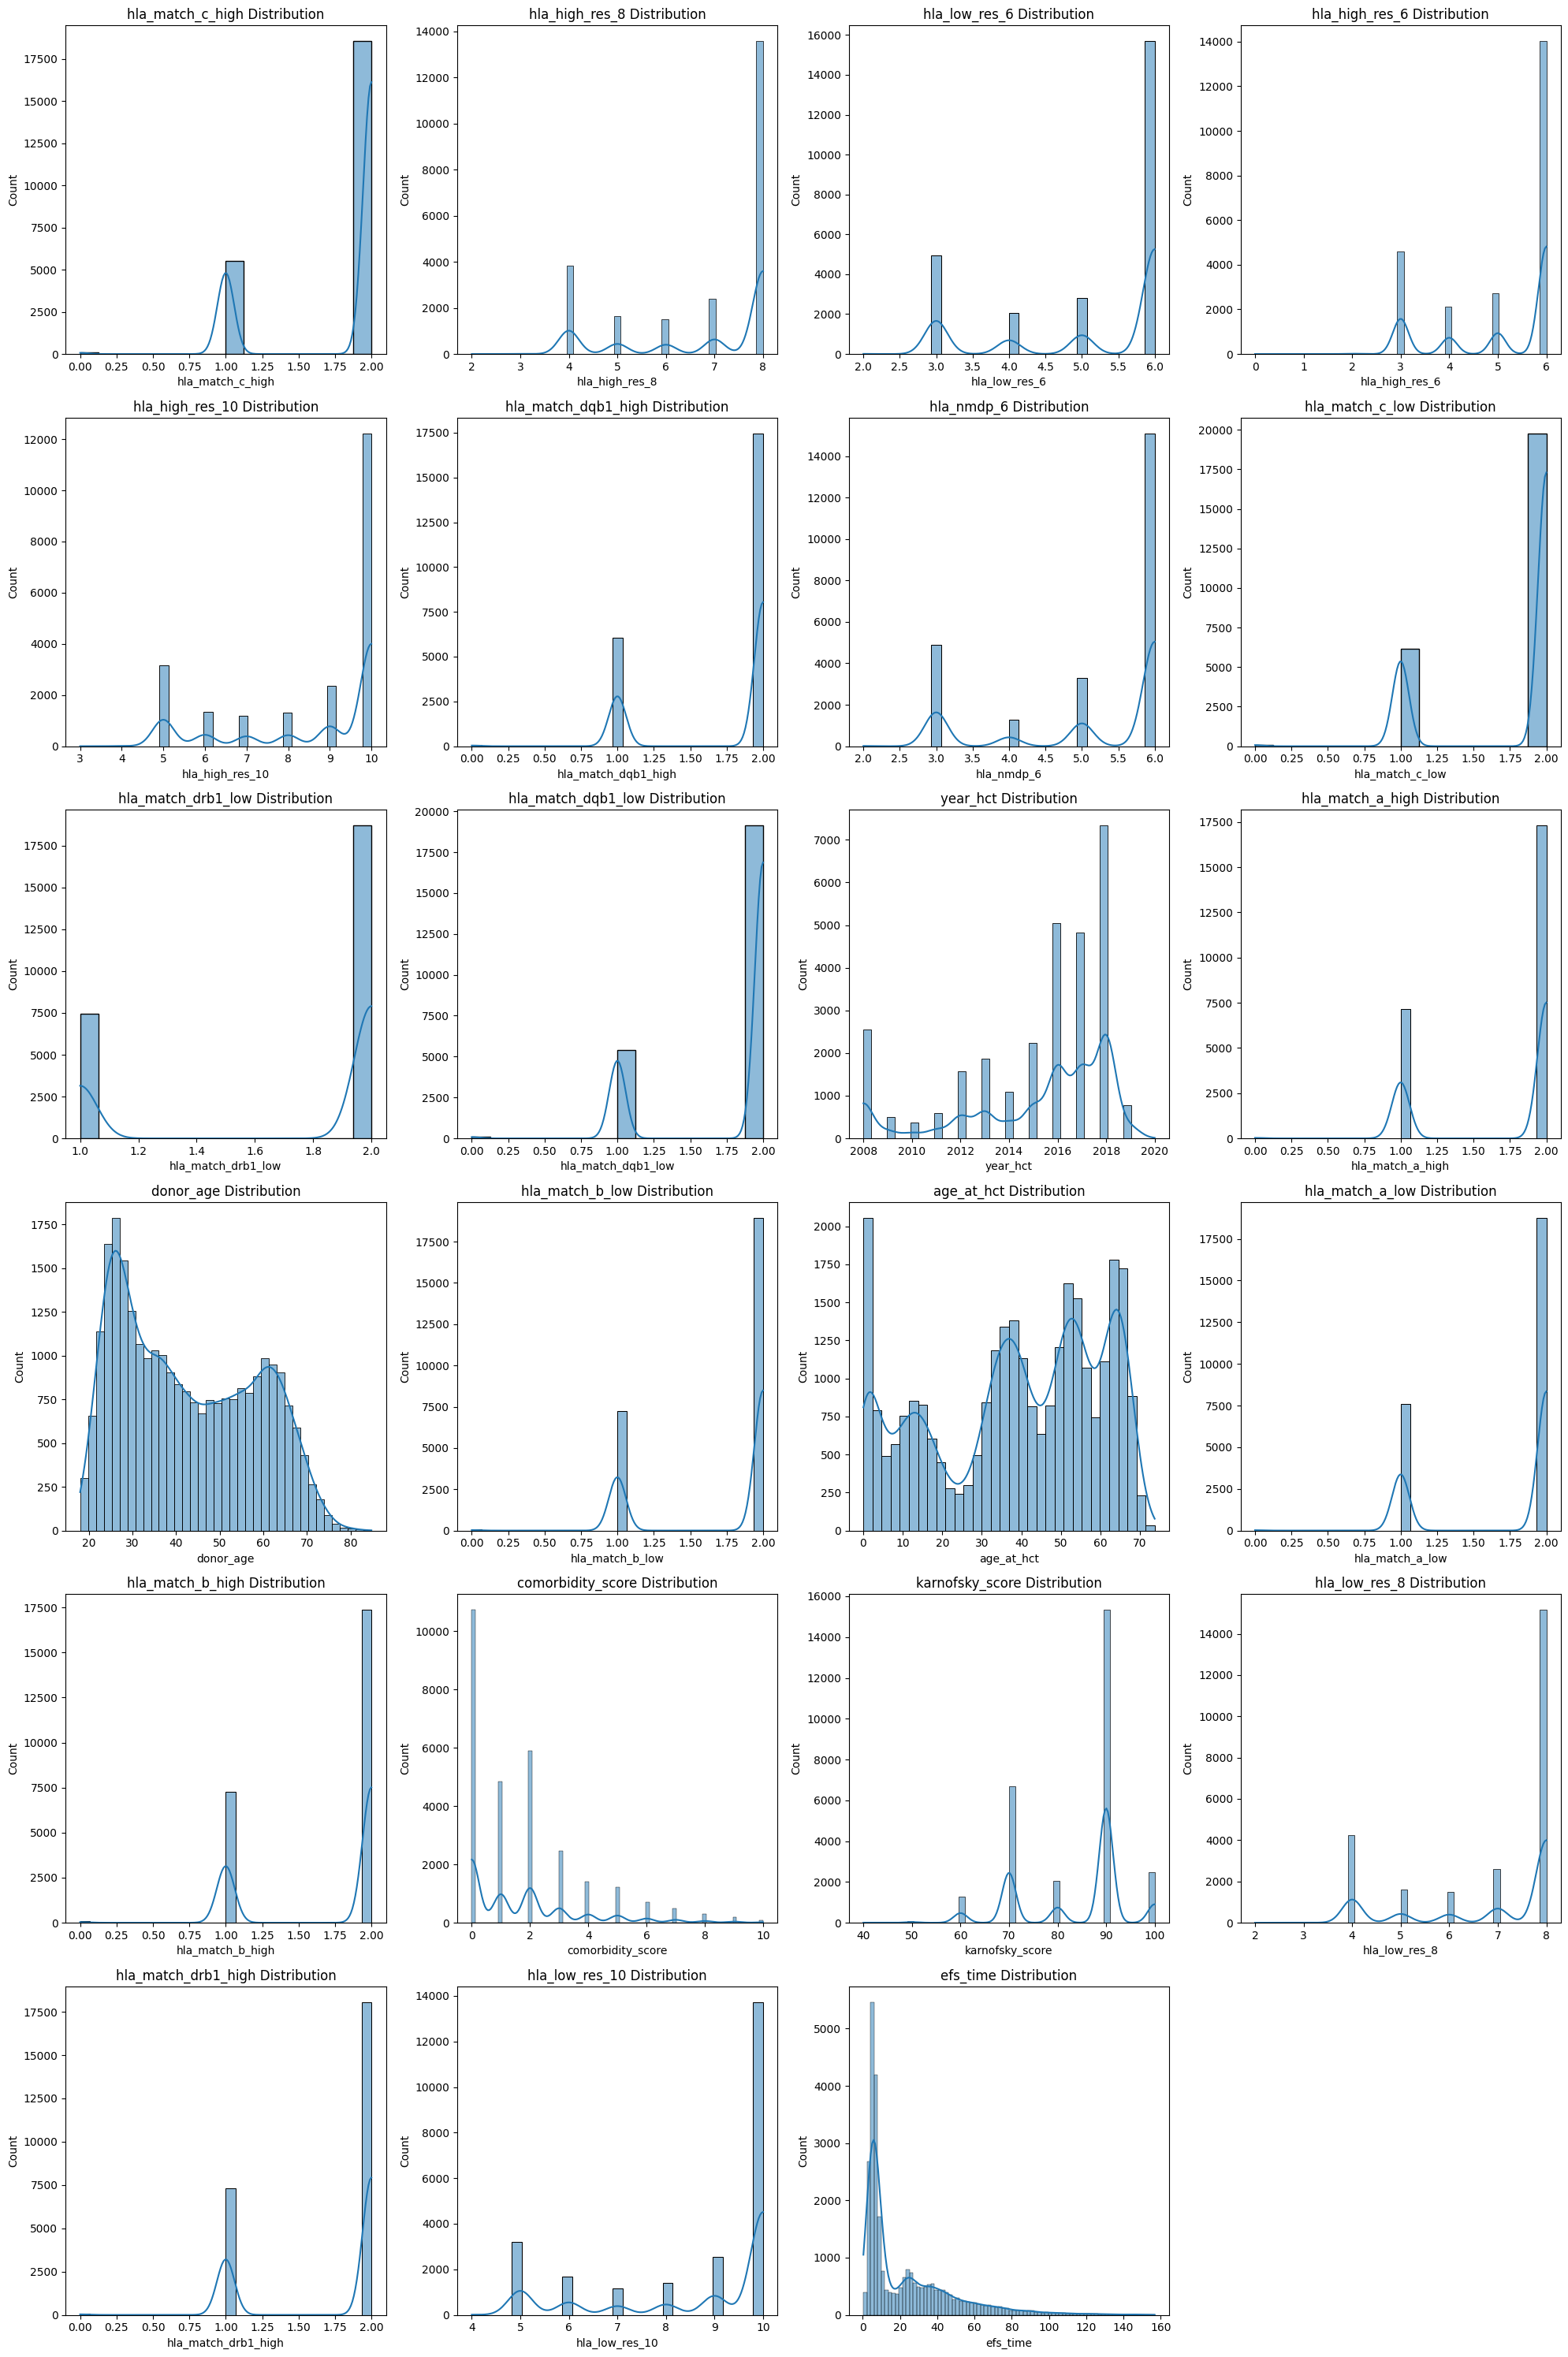

In [9]:
# Numerical variables analysis
num_cols = data_dict[data_dict['type'] == 'Numerical']['variable'].tolist()

# Calculate grid dimensions dynamically
n_cols = 4
n_rows = (len(num_cols) + n_cols - 1) // n_cols  # Round up division

plt.figure(figsize=(20, 5*n_rows))  # Adjust height based on rows
for i, col in enumerate(num_cols):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(train[col].dropna(), kde=True)  # Add dropna to handle missing values
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

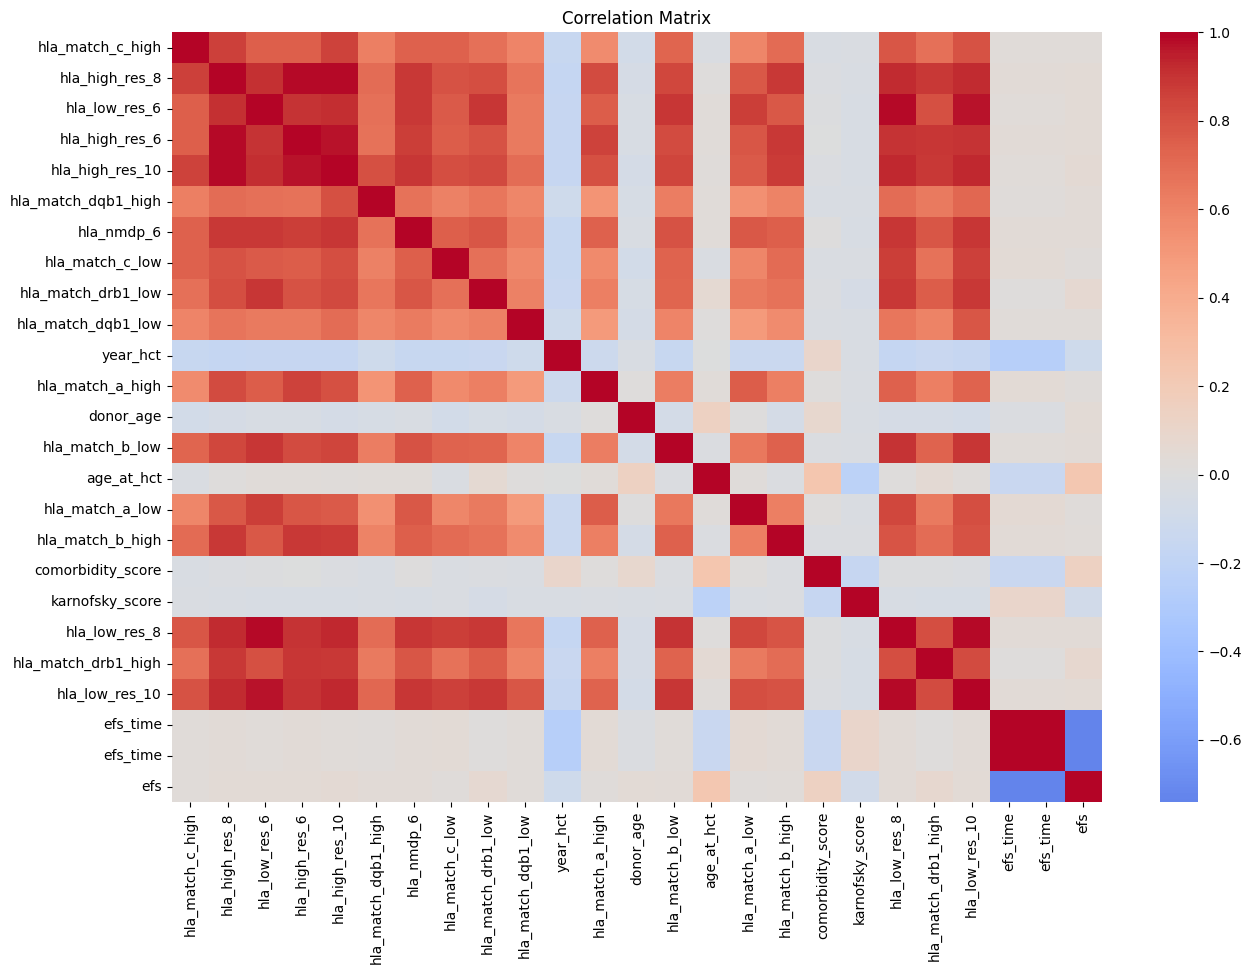

In [10]:
# Correlation analysis
plt.figure(figsize=(15, 10))
corr_matrix = train[num_cols + ['efs_time', 'efs']].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


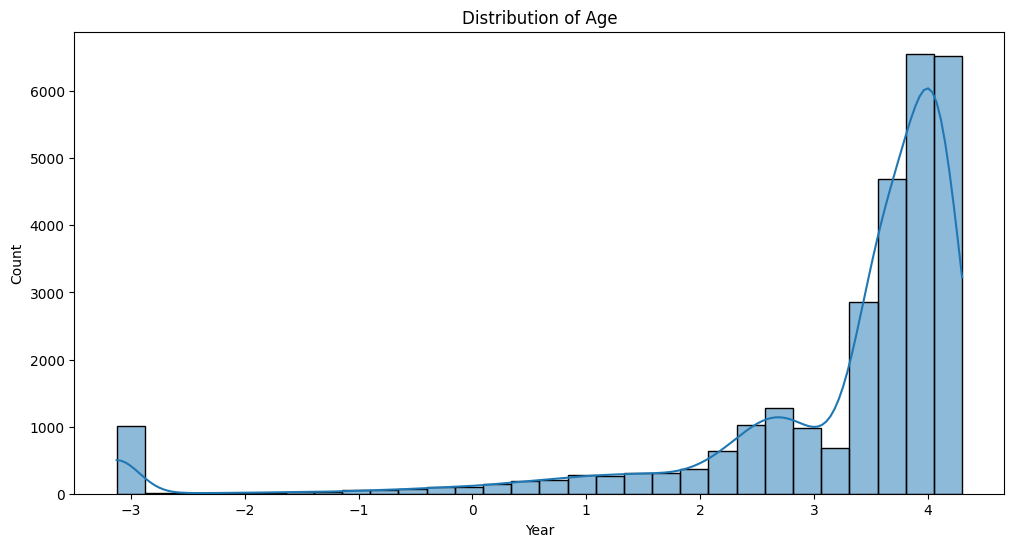

In [11]:

# Age distribution
plt.figure(figsize=(12, 6))
sns.histplot(np.log(train['age_at_hct']), bins=30, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Year')
plt.show()



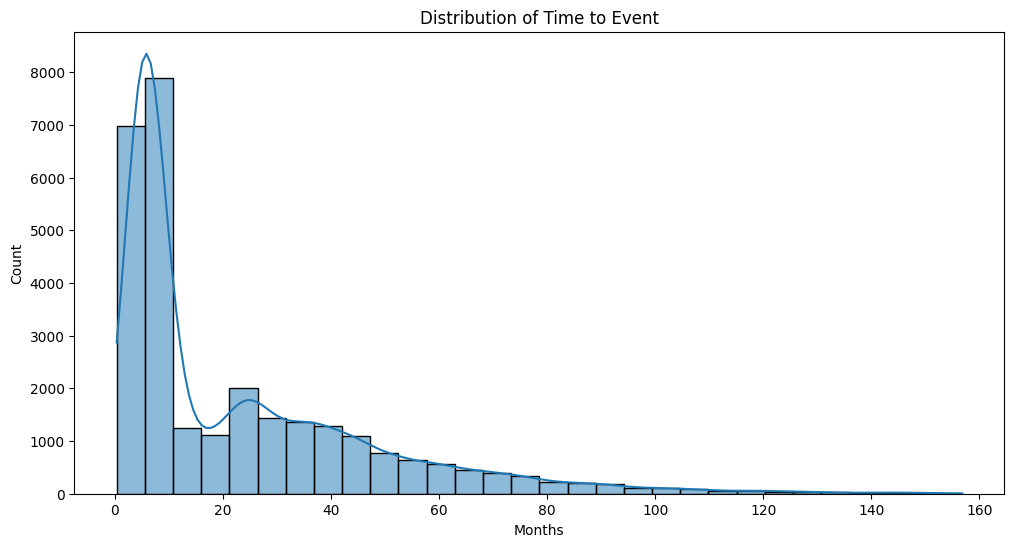

In [12]:
# Time-to-event distribution
plt.figure(figsize=(12, 6))
sns.histplot(train['efs_time'], bins=30, kde=True)
plt.title('Distribution of Time to Event')
plt.xlabel('Months')
plt.show()

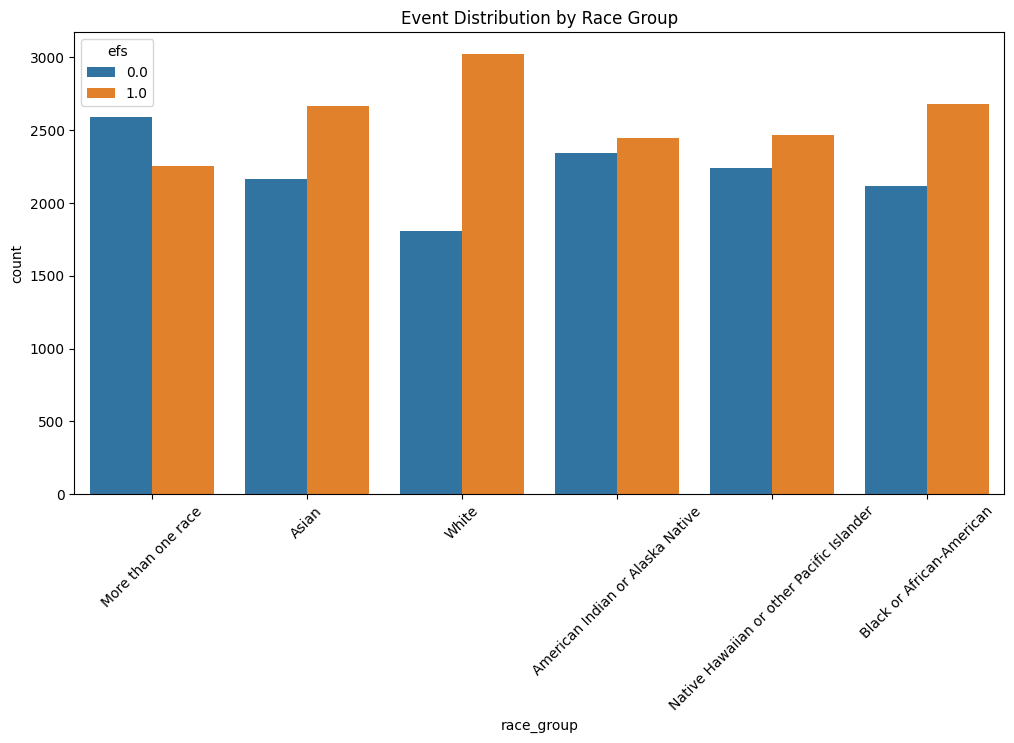

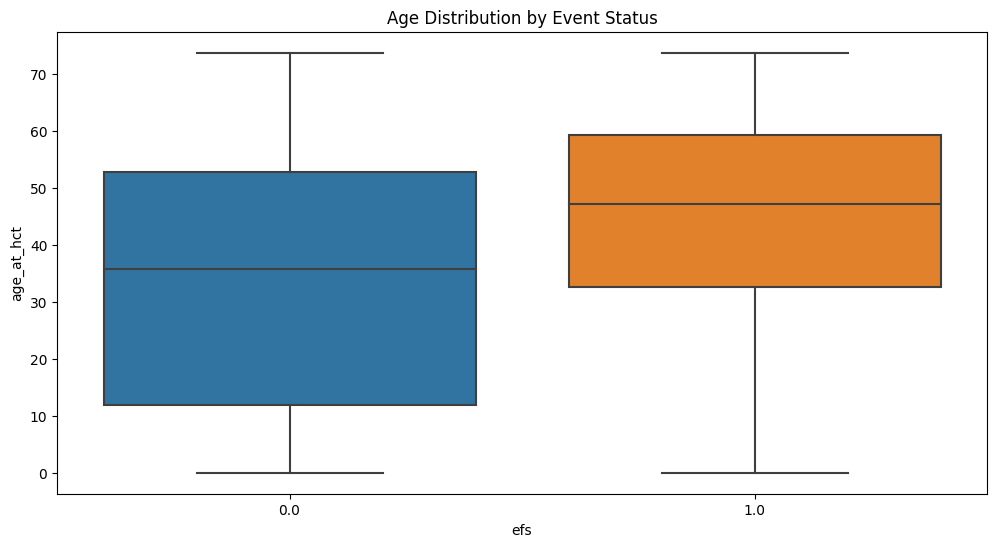

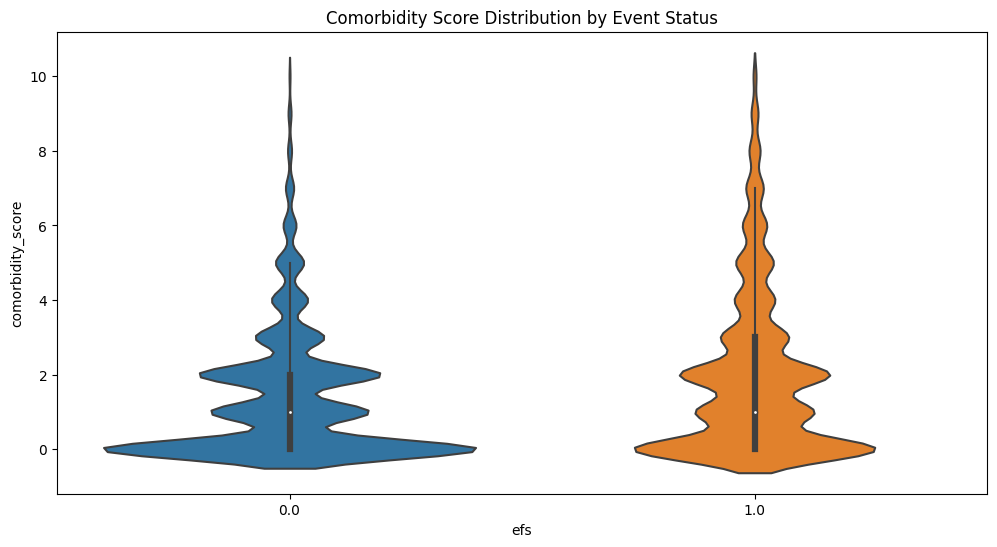

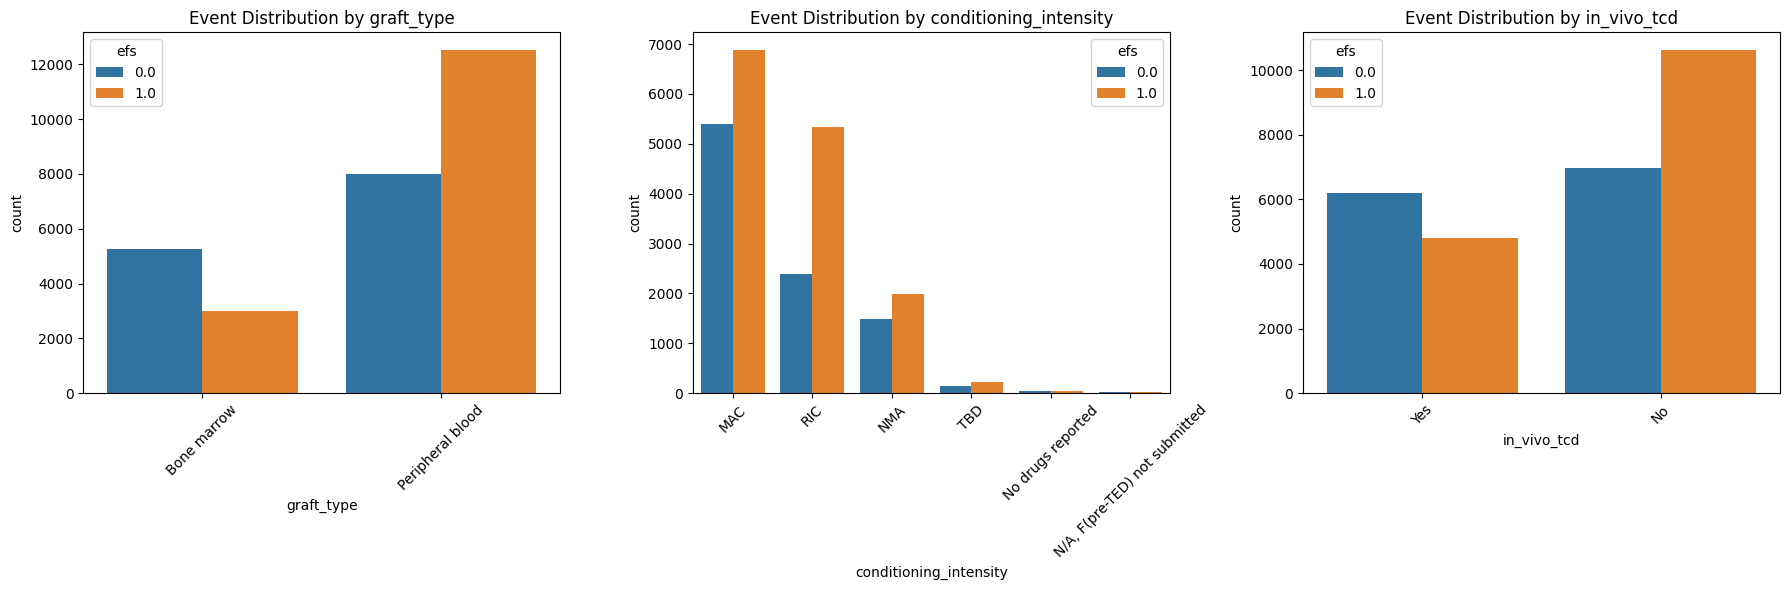


Statistical significance between event groups:
hla_match_c_high: t-stat = nan, p-value = nan
hla_high_res_8: t-stat = nan, p-value = nan
hla_low_res_6: t-stat = nan, p-value = nan
hla_high_res_6: t-stat = nan, p-value = nan
hla_high_res_10: t-stat = nan, p-value = nan
hla_match_dqb1_high: t-stat = nan, p-value = nan
hla_nmdp_6: t-stat = nan, p-value = nan
hla_match_c_low: t-stat = nan, p-value = nan
hla_match_drb1_low: t-stat = nan, p-value = nan
hla_match_dqb1_low: t-stat = nan, p-value = nan
year_hct: t-stat = nan, p-value = nan
hla_match_a_high: t-stat = nan, p-value = nan
donor_age: t-stat = nan, p-value = nan
hla_match_b_low: t-stat = nan, p-value = nan
age_at_hct: t-stat = nan, p-value = nan
hla_match_a_low: t-stat = nan, p-value = nan
hla_match_b_high: t-stat = nan, p-value = nan
comorbidity_score: t-stat = nan, p-value = nan
karnofsky_score: t-stat = nan, p-value = nan
hla_low_res_8: t-stat = nan, p-value = nan
hla_match_drb1_high: t-stat = nan, p-value = nan
hla_low_res_10: t

In [13]:
# Race group analysis
if 'race_group' in train.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=train, x='race_group', hue='efs')
    plt.title('Event Distribution by Race Group')
    plt.xticks(rotation=45)
    plt.show()

# Age analysis
if 'age_at_hct' in train.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='efs', y='age_at_hct', data=train)
    plt.title('Age Distribution by Event Status')
    plt.show()

# Comorbidity analysis
if 'comorbidity_score' in train.columns:
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='efs', y='comorbidity_score', data=train)
    plt.title('Comorbidity Score Distribution by Event Status')
    plt.show()

# Treatment modality analysis
treatment_cols = ['graft_type', 'conditioning_intensity', 'in_vivo_tcd']
plt.figure(figsize=(18, 6))
for i, col in enumerate(treatment_cols):
    plt.subplot(1, 3, i+1)
    sns.countplot(x=col, hue='efs', data=train)
    plt.title(f'Event Distribution by {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Statistical tests for numerical features
print("\nStatistical significance between event groups:")
for col in num_cols:
    group1 = train[train['efs'] == 'Event'][col]
    group0 = train[train['efs'] == 'Censoring'][col]
    t_stat, p_val = stats.ttest_ind(group1.dropna(), group0.dropna())
    print(f"{col}: t-stat = {t_stat:.2f}, p-value = {p_val:.4f}")

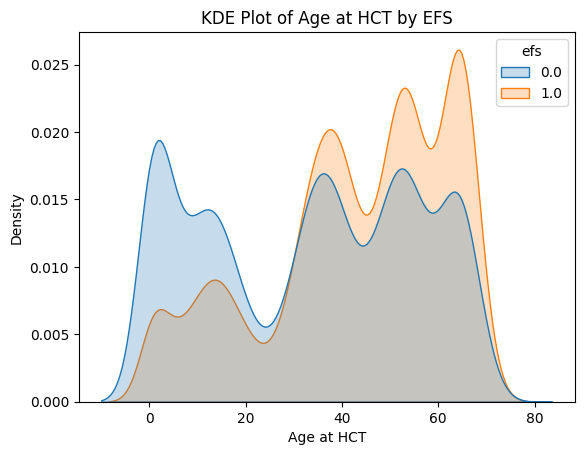

In [14]:
sns.kdeplot(data=train, x="age_at_hct", hue="efs", common_norm=False, fill=True)
plt.xlabel("Age at HCT")
plt.ylabel("Density")
plt.title("KDE Plot of Age at HCT by EFS")
plt.show()

# Data Preprocessing

## drop id and cols with more than 40% missing

In [15]:
def dropcols(df):
    df_dropped = df.drop(columns = ['cyto_score' , 'mrd_hct', 'tce_match','tce_div_match', 'cyto_score_detail', 'tce_imm_match'])
    return df_dropped
    
train1 = dropcols(train)
test1 = dropcols(test)

In [16]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   diabetes                26681 non-null  object 
 4   hla_match_c_high        24180 non-null  float64
 5   hla_high_res_8          22971 non-null  float64
 6   tbi_status              28800 non-null  object 
 7   arrhythmia              26598 non-null  object 
 8   hla_low_res_6           25530 non-null  float64
 9   graft_type              28800 non-null  object 
 10  vent_hist               28541 non-null  object 
 11  renal_issue             26885 non-null  object 
 12  pulm_severe             26665 non-null  object 
 13  prim_disease_hct        28800 non-null  object 
 14  hla_high_res_6          23516 non-null

In [17]:
# fill categorical with nan
categorical_cols = data_dict[data_dict['type'] == 'Categorical']['variable'].tolist()
for i in ['cyto_score' , 'mrd_hct', 'tce_match','tce_div_match', 'cyto_score_detail', 'tce_imm_match']:
    categorical_cols.remove(i)

In [18]:
train1[categorical_cols] = train1[categorical_cols].fillna('nan')

In [19]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28800 non-null  object 
 2   psych_disturb           28800 non-null  object 
 3   diabetes                28800 non-null  object 
 4   hla_match_c_high        24180 non-null  float64
 5   hla_high_res_8          22971 non-null  float64
 6   tbi_status              28800 non-null  object 
 7   arrhythmia              28800 non-null  object 
 8   hla_low_res_6           25530 non-null  float64
 9   graft_type              28800 non-null  object 
 10  vent_hist               28800 non-null  object 
 11  renal_issue             28800 non-null  object 
 12  pulm_severe             28800 non-null  object 
 13  prim_disease_hct        28800 non-null  object 
 14  hla_high_res_6          23516 non-null

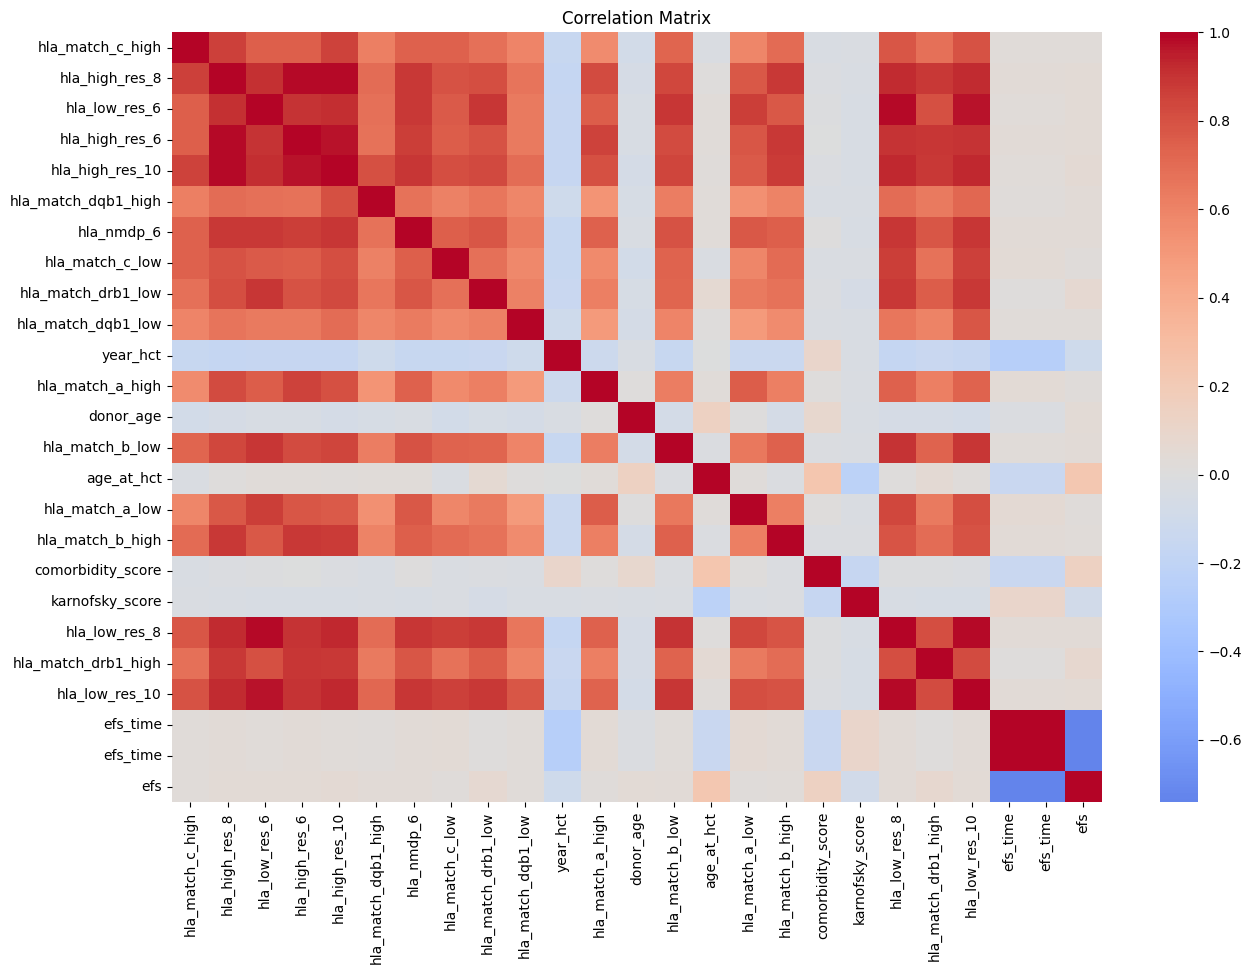

In [20]:
plt.figure(figsize=(15, 10))
corr_matrix = train1[num_cols + ['efs_time', 'efs']].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

In [21]:
def encode_dataframe(df):
    # Define ordinal columns
    ordinal_cols = ['dri_score', 'year_hct', 'comorbidity_score', 'conditioning_intensity', 'karnofsky_score']
    
    df_encoded = df.copy()
    
    df_encoded.drop(columns = ['race_group'], inplace = True)
    # Process each object column
    for col in df_encoded.select_dtypes(include='object').columns:
        if col in ordinal_cols:
            # Label encode ordinal columns (preserving order if known)
            df_encoded[col] = pd.Categorical(df_encoded[col]).codes
        else:
            # One-hot encode all other nominal object columns
            dummies = pd.get_dummies(df_encoded[col], prefix=col, drop_first=False)
            df_encoded = pd.concat([df_encoded.drop(col, axis=1), dummies], axis=1)
    df_encoded['race_group'] = df['race_group']        
    return df_encoded
train2 = encode_dataframe(train1)

In [22]:
test2 = encode_dataframe(test1)

In [23]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Columns: 158 entries, ID to race_group
dtypes: bool(130), float64(23), int64(2), int8(2), object(1)
memory usage: 9.3+ MB


In [24]:
train2['race_group']

0                               More than one race
1                                            Asian
2                               More than one race
3                                            White
4                 American Indian or Alaska Native
                           ...                    
28795                           More than one race
28796    Native Hawaiian or other Pacific Islander
28797    Native Hawaiian or other Pacific Islander
28798                    Black or African-American
28799                    Black or African-American
Name: race_group, Length: 28800, dtype: object

In [25]:
'''
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_cols = [
    'hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6',
    'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low',
    'hla_match_drb1_low', 'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high',
    'donor_age', 'hla_match_b_low', 'age_at_hct', 'hla_match_a_low',
    'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8',
    'hla_match_drb1_high', 'hla_low_res_10'
]

imp = SimpleImputer(missing_values=np.nan, strategy='median', add_indicator=True)
scaler = StandardScaler()

X_num_transformed = imp.fit_transform(train2[num_cols])
X_num_scaled = scaler.fit_transform(X_num_transformed)

train3 = train2.copy() 
train3[num_cols] = pd.DataFrame(X_num_scaled, columns=num_cols, index=train2.index) 
train3
'''

"\nfrom sklearn.impute import SimpleImputer\nfrom sklearn.preprocessing import StandardScaler\n\nnum_cols = [\n    'hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6',\n    'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low',\n    'hla_match_drb1_low', 'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high',\n    'donor_age', 'hla_match_b_low', 'age_at_hct', 'hla_match_a_low',\n    'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8',\n    'hla_match_drb1_high', 'hla_low_res_10'\n]\n\nimp = SimpleImputer(missing_values=np.nan, strategy='median', add_indicator=True)\nscaler = StandardScaler()\n\nX_num_transformed = imp.fit_transform(train2[num_cols])\nX_num_scaled = scaler.fit_transform(X_num_transformed)\n\ntrain3 = train2.copy() \ntrain3[num_cols] = pd.DataFrame(X_num_scaled, columns=num_cols, index=train2.index) \ntrain3\n"

In [26]:
class ParticipantVisibleError(Exception):
    pass


def custom_score(solution, submission, row_id_column_name, prediction_label='prediction', print_info=True):
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    
    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_dict = {}
    for race in sorted(merged_df_race_dict.keys()):
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])

        metric_dict[race] = c_index_race

    race_c_index = list(metric_dict.values())
    c_score = float(np.mean(race_c_index) - np.std(race_c_index))
    if print_info:
        print(f"{Fore.GREEN}{Style.BRIGHT}# c-index={c_score:.4f}, mean={np.mean(race_c_index):.4f} std={np.std(race_c_index):.4f}{Style.RESET_ALL}")
    
    return c_score, metric_dict


def display_overall(df):
    
    race_groups = [
        'American Indian or Alaska Native', 'Asian',
       'Black or African-American', 'More than one race',
       'Native Hawaiian or other Pacific Islander', 'White'
    ]
    df['mean'] = df[race_groups].mean(axis=1)
    df['std'] = np.std(df[race_groups], axis=1)
    df['score'] = df['mean'] - df['std']
    df = df.T
    df['Overall'] = df.mean(axis=1)
    temp = df.drop(index=['std']).values
    display(df
            .iloc[:len(race_groups)]
            .style
            .format(precision=4)
            .background_gradient(axis=None, vmin=temp.min(), vmax=temp.max(), cmap="cool")
            .concat(df.iloc[len(race_groups):].style.format(precision=3))
           )

In [27]:
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    """
    Transform using survival probability estimates
    """
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    
    return y

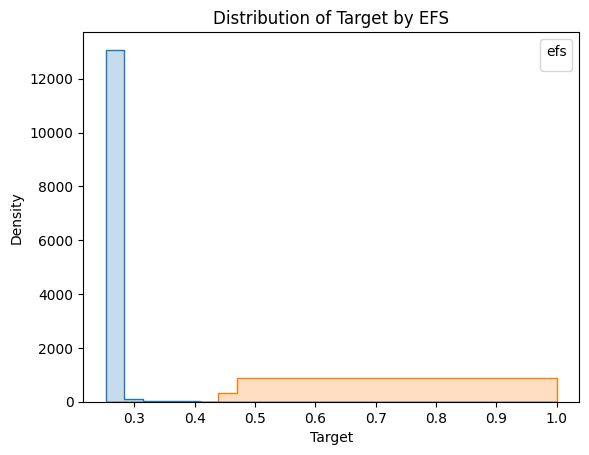

In [28]:
train2["label"] = transform_survival_probability(train2, time_col='efs_time', event_col='efs')
train2.loc[train2['efs']==0, 'label'] -= 0.2

sns.histplot(data=train2, x='label', hue='efs', element='step', common_norm=False)
plt.legend(title='efs')
plt.title('Distribution of Target by EFS')
plt.xlabel('Target')
plt.ylabel('Density')
plt.show()

In [29]:
RMV = ["ID","efs","efs_time","label",'y','kfold']
FEATURES = [c for c in train2.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 155 FEATURES: ['dri_score', 'hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'conditioning_intensity', 'year_hct', 'hla_match_a_high', 'donor_age', 'hla_match_b_low', 'age_at_hct', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10', 'psych_disturb_No', 'psych_disturb_Not done', 'psych_disturb_Yes', 'psych_disturb_nan', 'diabetes_No', 'diabetes_Not done', 'diabetes_Yes', 'diabetes_nan', 'tbi_status_No TBI', 'tbi_status_TBI + Cy +- Other', 'tbi_status_TBI +- Other, -cGy, fractionated', 'tbi_status_TBI +- Other, -cGy, single', 'tbi_status_TBI +- Other, -cGy, unknown dose', 'tbi_status_TBI +- Other, <=cGy', 'tbi_status_TBI +- Other, >cGy', 'tbi_status_TBI +- Other, unknown dose', 'arrhythmia_No', 'arrhythmia_Not done', 'arrhythmia_Yes', 'arrhythmia_nan', '

In [30]:
CAT_FEATURES = []
for c in FEATURES:
    if train2[c].dtype=="object":
        CAT_FEATURES.append(c)
        train2[c] = train2[c].fillna("NAN")
        test2[c] = test2[c].fillna("NAN")

In [31]:
combined = pd.concat([train2, test2], axis=0, ignore_index=True)
print("The CATEGORICAL FEATURES: ",end="")
for c in FEATURES:
    if c in CAT_FEATURES:
        print(f"{c}, ", end="")
        combined[c] = combined[c].astype("category")
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")

traintree = combined.iloc[:len(train2)].copy()
testtree = combined.iloc[len(train2):].reset_index(drop=True).copy()

The CATEGORICAL FEATURES: race_group, 

In [32]:
from sklearn.model_selection import StratifiedKFold, train_test_split

folds = 5
traintree['kfold'] = -1  

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
groups = traintree['efs'].astype(str)
for fold, (train_idx, val_idx) in enumerate(skf.split(X=traintree, y=groups)):
    traintree.loc[val_idx, 'kfold'] = fold

In [33]:
def CIndexMetric_XGB(y_true, y_pred):
    ds_pred["prediction"] = y_pred
    cindex_score, _ = custom_score(ds_true.copy(), ds_pred.copy(), "ID", print_info=False)
    return -cindex_score

def CIndexMetric_LGB(y_true, y_pred):
    ds_pred["prediction"] = y_pred
    cindex_score, _ = custom_score(ds_true.copy(), ds_pred.copy(), "ID", print_info=False)
    return ('C-Index', cindex_score, True)

In [34]:
traintree

,ID,dri_score,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,...,cardiac_Not done,cardiac_Yes,cardiac_nan,pulm_moderate_No,pulm_moderate_Not done,pulm_moderate_Yes,pulm_moderate_nan,race_group,label,kfold
0,0,7,NaN,NaN,6.0,6.0,NaN,2.0,6.0,2.0,...,False,False,False,True,False,False,False,More than one race,0.258687,2
1,1,2,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,...,False,False,False,False,False,True,False,Asian,0.847759,3
2,2,7,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,...,False,False,False,True,False,False,False,More than one race,0.262424,4
3,3,0,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,...,False,False,False,True,False,False,False,White,0.256661,4
4,4,0,2.0,8.0,6.0,6.0,10.0,2.0,5.0,2.0,...,False,False,False,True,False,False,False,American Indian or Alaska Native,0.264674,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,28795,3,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,...,False,False,True,True,False,False,False,More than one race,0.262846,1
28796,28796,0,1.0,4.0,5.0,3.0,6.0,2.0,4.0,1.0,...,False,True,False,False,False,True,False,Native Hawaiian or other Pacific Islander,0.825494,1
28797,28797,9,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,...,False,False,True,True,False,False,False,Native Hawaiian or other Pacific Islander,0.261142,2
28798,28798,7,1.0,4.0,3.0,3.0,5.0,1.0,3.0,1.0,...,False,False,False,True,False,False,False,Black or African-American,0.258404,0


In [35]:
traintree['race_group']

0                               More than one race
1                                            Asian
2                               More than one race
3                                            White
4                 American Indian or Alaska Native
                           ...                    
28795                           More than one race
28796    Native Hawaiian or other Pacific Islander
28797    Native Hawaiian or other Pacific Islander
28798                    Black or African-American
28799                    Black or African-American
Name: race_group, Length: 28800, dtype: category
Categories (6, object): ['American Indian or Alaska Native', 'Asian', 'Black or African-American', 'More than one race', 'Native Hawaiian or other Pacific Islander', 'White']

In [36]:
traintree[traintree.select_dtypes(include=['object']).columns] = traintree.select_dtypes(include=['object']).astype('category')


In [37]:
#no preprocessing to test metric
test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
train["label"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')
train.loc[train['efs']==0, 'label'] -= 0.2
RMV = ["ID","efs","efs_time","label",'y','kfold']
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")
CAT_FEATURES = []
for c in FEATURES:
    if train[c].dtype=="object":
        CAT_FEATURES.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
combined = pd.concat([train, test], axis=0, ignore_index=True)
print("The CATEGORICAL FEATURES: ",end="")
for c in FEATURES:
    if c in CAT_FEATURES:
        print(f"{c}, ", end="")
        combined[c] = combined[c].astype("category")
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")

train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()
folds = 5
train['kfold'] = -1  

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
groups = train['efs'].astype(str)
for fold, (train_idx, val_idx) in enumerate(skf.split(X=train, y=groups)):
    train.loc[val_idx, 'kfold'] = fold

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']
The CATEGORICAL FEATURES: dri_score, psy

In [38]:
%%time
    
oof_lgb = train[['kfold','ID','efs','efs_time','label','race_group']].copy()
oof_lgb['prediction'] = 0.0
feature_importances_lgb = pd.DataFrame()
feature_importances_lgb['feature'] = FEATURES
metric_df = []

for fold in range(skf.n_splits):
    
    x_train = train[train.kfold != fold].copy()
    x_valid = train[train.kfold == fold].copy()

    y_train = x_train['label']
    y_valid = x_valid['label']
    y_label = x_valid['efs']

    x_train = x_train[FEATURES]
    x_valid = x_valid[FEATURES]

    ds_true = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    ds_pred = oof_lgb.loc[oof_lgb.kfold==fold, ["ID"]].copy().reset_index(drop=True)

    lgb_params = {
        'max_depth': 6,
        'num_leaves': 40,
        'learning_rate': 0.03,
        'n_estimators': 10000,
        'objective': 'l2',
        'subsample': 0.8,
        'colsample_bytree': 0.5,
        'n_jobs': -1,
        'verbose': -1,
        'metric': 'None' # only show the custom metric
    }
    clf = LGBMRegressor(**lgb_params)
    clf.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        categorical_feature=CAT_FEATURES,
        eval_metric=CIndexMetric_LGB, # the custom metric
        callbacks=[callback.log_evaluation(500), callback.early_stopping(50)]
    )
    feature_importances_lgb[f'fold_{fold + 1}'] = clf.feature_importances_

    preds_valid = clf.predict(x_valid)
    oof_lgb.loc[oof_lgb.kfold==fold, 'prediction'] = preds_valid

    joblib.dump(clf, f"lgb_model_{fold}.pkl")

    y_true = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
    y_pred = oof_lgb.loc[oof_lgb.kfold==fold, ["ID","prediction"]].copy().reset_index(drop=True)
    m, metric_dict = custom_score(y_true, y_pred, "ID", print_info=True)
    metric_df.append(metric_dict)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[419]	valid_0's C-Index: 0.66157
# c-index=0.6616, mean=0.6772 std=0.0156
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[398]	valid_0's C-Index: 0.675328
# c-index=0.6753, mean=0.6919 std=0.0166
Training until validation scores don't improve for 50 rounds
[500]	valid_0's C-Index: 0.672428
Early stopping, best iteration is:
[451]	valid_0's C-Index: 0.672806
# c-index=0.6728, mean=0.6841 std=0.0113
Training until validation scores don't improve for 50 rounds
[500]	valid_0's C-Index: 0.672804
Early stopping, best iteration is:
[682]	valid_0's C-Index: 0.675063
# c-index=0.6751, mean=0.6885 std=0.0134
Training until validation scores don't improve for 50 rounds
[500]	valid_0's C-Index: 0.66819
Early stopping, best iteration is:
[679]	valid_0's C-Index: 0.669463
# c-index=0.6695, mean=0.6797 std=0.0102
CPU times: user 7min 49s, sys: 1.17 s, total:

In [39]:
y_true = oof_lgb[["ID","efs","efs_time","race_group"]].copy().reset_index(drop=True)
y_pred = oof_lgb[["ID","prediction"]].copy().reset_index(drop=True)
m, _ = custom_score(y_true, y_pred, "ID", print_info=True)
print(f"Overall official SCORE: {m:.5f}")

metric_df_ = pd.DataFrame(metric_df)
display_overall(metric_df_)

# c-index=0.6756, mean=0.6841 std=0.0085
Overall official SCORE: 0.67559


,0,1,2,3,4,Overall
American Indian or Alaska Native,0.7067,0.6951,0.6894,0.6871,0.6705,0.6898
Asian,0.6821,0.7241,0.6767,0.7137,0.6944,0.6982
Black or African-American,0.6672,0.6885,0.6989,0.6839,0.6692,0.6815
More than one race,0.6579,0.6920,0.6925,0.6960,0.6906,0.6858
Native Hawaiian or other Pacific Islander,0.6681,0.6697,0.6826,0.6752,0.6829,0.6757
White,0.6812,0.6820,0.6644,0.6748,0.6704,0.6745
mean,0.677,0.692,0.684,0.688,0.680,0.684
std,0.016,0.017,0.011,0.013,0.010,0.013
score,0.662,0.675,0.673,0.675,0.669,0.671


In [40]:
feature_importances_lgb['importance'] = feature_importances_lgb.drop('feature', axis=1).mean(axis=1)
feature_importances_lgb = feature_importances_lgb.sort_values('importance', ascending=False).reset_index(drop=True)
feature_importances_lgb.head(20)

,feature,fold_1,fold_2,fold_3,fold_4,fold_5,importance
0,donor_age,1535,1327,1543,2738,2633,1955.2
1,age_at_hct,1270,1164,1440,2224,2209,1661.4
2,prim_disease_hct,807,777,812,1136,1133,933.0
3,year_hct,806,750,765,1106,1208,927.0
4,comorbidity_score,710,699,756,1120,1133,883.6
5,gvhd_proph,691,692,737,1106,1016,848.4
6,karnofsky_score,569,622,723,980,971,773.0
7,dri_score,654,631,696,932,889,760.4
8,race_group,391,398,411,614,568,476.4
9,cyto_score,345,387,361,511,532,427.2


In [41]:
sub = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv', index_col = False)
sub['prediction'] = y_pred
sub.to_csv('submission.csv', index = False)

In [42]:
sub

,ID,prediction
0,28800,0.337983
1,28801,0.618604
2,28802,0.231850
